In [133]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness, RandomZoom, RandomTranslation

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

## helper function to load and parse annotations

In [2]:
# relative path to the dataset -> change as needed
PATH = "../gesture_dataset_sample/"

In [3]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{PATH}_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [17]:
# pretty-print first element
print(json.dumps(annotations['like']['00ae4da4-9462-4804-ab99-5d2e409cd4b2'], indent=2))

{
  "bboxes": [
    [
      0.56004864,
      0.55650459,
      0.18327319,
      0.17768826
    ]
  ],
  "labels": [
    "like"
  ],
  "landmarks": [
    [
      [
        0.730763142633069,
        0.683576445015974
      ],
      [
        0.7041104627480214,
        0.6497426990629613
      ],
      [
        0.6622941789915147,
        0.6198364619279283
      ],
      [
        0.631479293229952,
        0.5958549780856107
      ],
      [
        0.6237001389824903,
        0.5695294644313559
      ],
      [
        0.6181716804176802,
        0.6237527867813881
      ],
      [
        0.5753533112326704,
        0.6527713001675327
      ],
      [
        0.5934691423311418,
        0.660826420087605
      ],
      [
        0.6107194047335265,
        0.6557881127689615
      ],
      [
        0.6203217131762268,
        0.6440693101816604
      ],
      [
        0.576915996432587,
        0.6750395627716688
      ],
      [
        0.5972215956543832,
        0.6796856893

## helper function to pre-process images (color channel conversion and resizing)

In [4]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [5]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'{PATH}/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

['hyperparameters.ipynb']


  0%|          | 0/250 [00:00<?, ?it/s]

['hyperparameters.ipynb']


  0%|          | 0/250 [00:00<?, ?it/s]

## let's have a look at one of the images

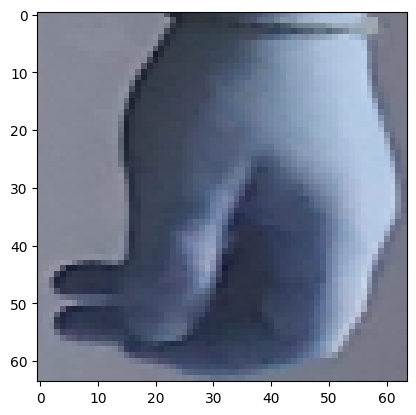

In [6]:
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

512
128
512
128


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [8]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


# Exploring

<div class="alert alert-info"><b>PARAM:</b> Data Augmentation</div>

<details open>
<summary> <b> General Approach </b> </summary>

- using the keras data augmentation layer
- see:
  - https://www.datacamp.com/tutorial/complete-guide-data-augmentation
  - https://www.tensorflow.org/tutorials/images/data_augmentation 
- values either kept similar to tutorials, i.e. not too big
- saveing the history and the confusion matrix to .json files (see: `\logs`)
- noting down the accuracy score and inference time in a .txt file (see: `notes.txt`)

****

**00 - Flip and Contrast (default)**
- the original configuration of the model
- `model.add(RandomFlip('horizontal'))`
- `model.add(RandomContrast(0.1))`

**01 - Rotate and Flip**
- `model.add(RandomFlip('horizontal_and_vertical'))`
- `model.add(RandomRotation(0.2))`
- Assumptions:
  - acc probably pretty good + okay improvement
  - augmentation doesn't change the image too much -> so no worries, that it learns the wrong things
  - should help with learning diff positions of features in the image
- Findings:
  - model worse than 00, so no improvement
  - acc is pretty good, but nothing great

**02 - Brightness**
- `model.add(RandomBrightness(0.2))`
- 0.2 -> used in keras example + not too big of a change
- Assupmtions:
  - okay to good acc ~ 80%
  - prop helps with predicting images with diff light situations
  - maybe bad, bc. light/darkness can wash out images -> so obscure features
- Findings:
  - really bad acc
  - thinks most gestures are stop, prob. bc. stop has biggest surface space and washed out images often have big "surfaces"
  - time is fine

**03 - Zoom**
- `model.add(RandomZoom((-0.2, 0.2)))`
- (-0.2, 0.2) for zoom in & out btw. the two values 
- Assumptions:
  - okay acc around 60%
  - basically vanilla data, with some extra distances injected 
  - so should be better than no augmentation 
  - can't think of this learning stuff wrong, bc. augmentation not that invasive
- Findings
  - very good acc (better than expected)
  - assumptions correct except acc

**04 - Contrast**
- `model.add(RandomContrast(0.2))`
- Assumptions
  - good acc ~ 80%
  - contrast doesn't really obscure features in the data, just offers different "view"
- Findings
  - bit better acc than zoom, prop. bc. no possible cutoff of features
  - assumptions pretty correct

**05 - Translation**
- `model.add(RandomTranslation(-0.2, 0.2))`
- small amount of translation in both direction
- Assumptions
  - good acc ~ 80%
  - probably helps for most images, bc. diff placement of features
  - might bring issues, if translation obscurres features
  - prob. not better than contrast & zoom, but better than flip/rotate
- Findings
  - actually better than contrast & zoom
  - probably translate amount small enough, that nothing got obscured

**06 - Contrast & Translation**
- merge both 04 & 05 together
- `model.add(RandomContrast(0.2))`
- `model.add(RandomTranslation(-0.2, 0.2))`
- Assumptions
  - combine best single augments should make model better
  - don't think will interfere with each other, bc. 1 space transformation & 1 color transformation ( no overlap)
  - inference time probably little worse, bc. more data 
- Findings
  - not better than by themselves
  - same acc as contrast + little faster ic 

</details>

For detailed reporting see [below](#comparison)

In [228]:
# filename = "default.json"
param = "bright"
history_file = f"logs/{param}-history.json"
model_file = f"logs/{param}-model.keras"
conf_file = f"logs/{param}-conf.json"

In [229]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomBrightness(0.2))
# model.add(RandomFlip('horizontal'))
# model.add(RandomContrast(0.1))
## #model.add(RandomBrightness(0.1))
## #model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

c:\Users\Leonie\Documents\Uni_Regensburg\SS2024\ITT\assignments\assignment-5-cnn-LeS-crypto\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## now, we can train the model using the fit() function
## this will take a while

In [230]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3605 - loss: 2.2123 - val_accuracy: 0.3516 - val_loss: 1.0933 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3500 - loss: 1.2896 - val_accuracy: 0.3516 - val_loss: 1.0871 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4114 - loss: 1.1775 - val_accuracy: 0.3516 - val_loss: 1.0877 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3395 - loss: 1.2459 - val_accuracy: 0.3516 - val_loss: 1.0871 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4211 - loss: 1.1590 - val_accuracy: 0.3516 - val_loss: 1.0865 - learning_rate: 2.0000e-04
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3656 - loss: 1.1553 - val_accuracy: 0.3516 - val_loss: 1.0858 - learning_rate: 2.0000e-04
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3732 - loss: 1.0876 -

In [145]:
# let's have a look at our model
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_contrast_4               │ (8, 64, 64, 3)         │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_1            │ (8, 64, 64, 3)         │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (8, 64, 64, 64)        │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (8, 16, 16, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (8, 16, 16, 32)        │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (8, 6, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (8, 6, 6, 32)          │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (8, 288)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (8, 64)                │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (8, 64)                │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (8, 3)                 │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,843 (1.13 MB)

 Trainable params: 98,947 (386.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 197,896 (773.04 KB)

Save the history dict

In [146]:
# https://stackoverflow.com/a/53101097 
import json
with open(history_file, 'w') as f:
    json.dump(history.history, f, indent=4)


## Plot accuracy and loss of the training process

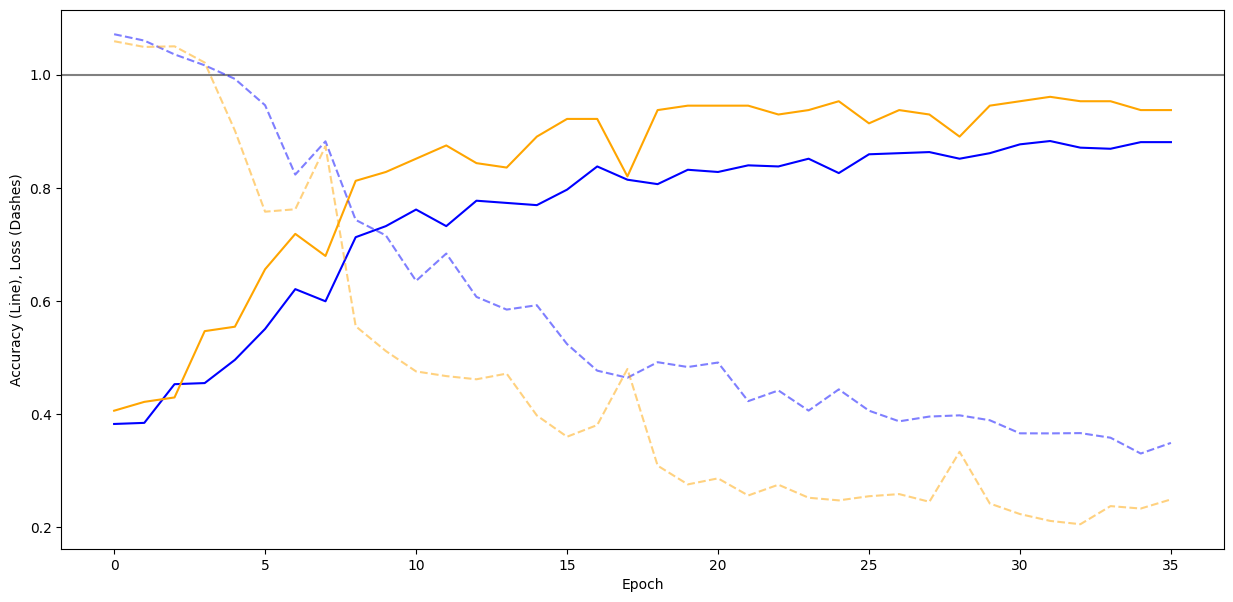

In [147]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [100]:
# model.save('gesture_recognition.keras')
# model.save(model_file)

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## visualize classification results with a confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
inference time = 0.10951662063598633 sec
probabilities [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
accuracy_score = 0.3515625


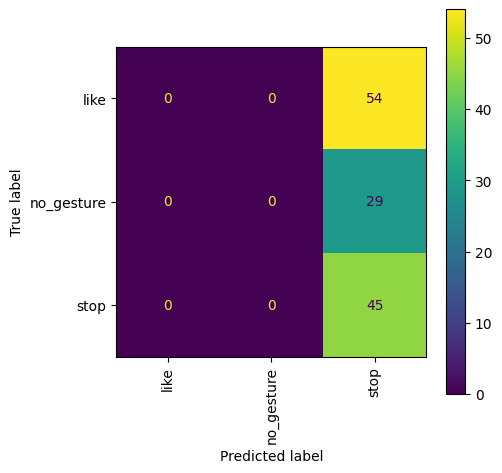

In [302]:
import time
# let the model make predictions for our training data

start = time.time() # measure time
y_predictions = model.predict(X_test)
end = time.time()
print("inference time =", (end-start), "sec") # time in seconds


# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# get the accuracy score
acc_score = accuracy_score(y_test, y_predictions)
print("accuracy_score =", acc_score)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(5, 5))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

In [232]:
# save confidence matrix
# https://stackoverflow.com/a/32850511
with open(conf_file, 'w') as f:
    json.dump(conf_matrix.tolist(), f, indent=4)

# Comparison

In [234]:
# load data from parameter tests
keys = ["bright", "contrast", "default", "rota_flip", "translate", "zoom", "contrast_translate"]
histories = {}
confusions = {}

for key in keys:
    with open(f"logs/{key}-history.json", 'r') as f:
        histories[key] = json.load(f)
    
    with open(f"logs/{key}-conf.json", 'r') as f:
        confusions[key] = json.load(f)

print("histories", histories.keys())
print("confusion matricies", confusions.keys())

histories dict_keys(['bright', 'contrast', 'default', 'rota_flip', 'translate', 'zoom', 'contrast_translate'])
confusion matricies dict_keys(['bright', 'contrast', 'default', 'rota_flip', 'translate', 'zoom', 'contrast_translate'])


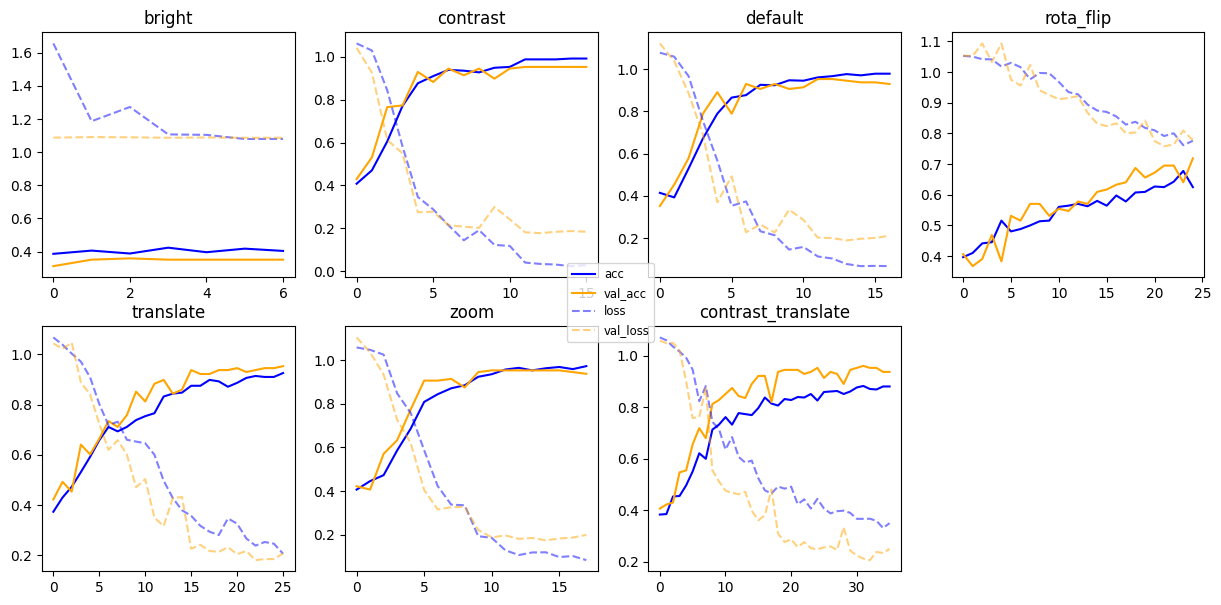

In [226]:
# display a grid of plots
num_of_plots = len(keys)
cols = 4
rows = 2
i = 1
fig = plt.figure(figsize=(15, 7))

for key in histories:
    history = histories[key]

    loss = history['loss']
    val_loss = history['val_loss']
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    plt.subplot(rows, cols, i)
    plt.title(key)

    if i == 1:
        plt.plot(accuracy, color='blue', label="acc")
        plt.plot(val_accuracy, color='orange', label="val_acc")
        plt.plot(loss, '--', color='blue', alpha=0.5, label="loss")
        plt.plot(val_loss, '--', color='orange', alpha=0.5, label="val_loss")
    else:
        plt.plot(accuracy, color='blue')
        plt.plot(val_accuracy, color='orange')
        plt.plot(loss, '--', color='blue', alpha=0.5)
        plt.plot(val_loss, '--', color='orange', alpha=0.5)
    i += 1

plt.figlegend(loc="center", fontsize="small")

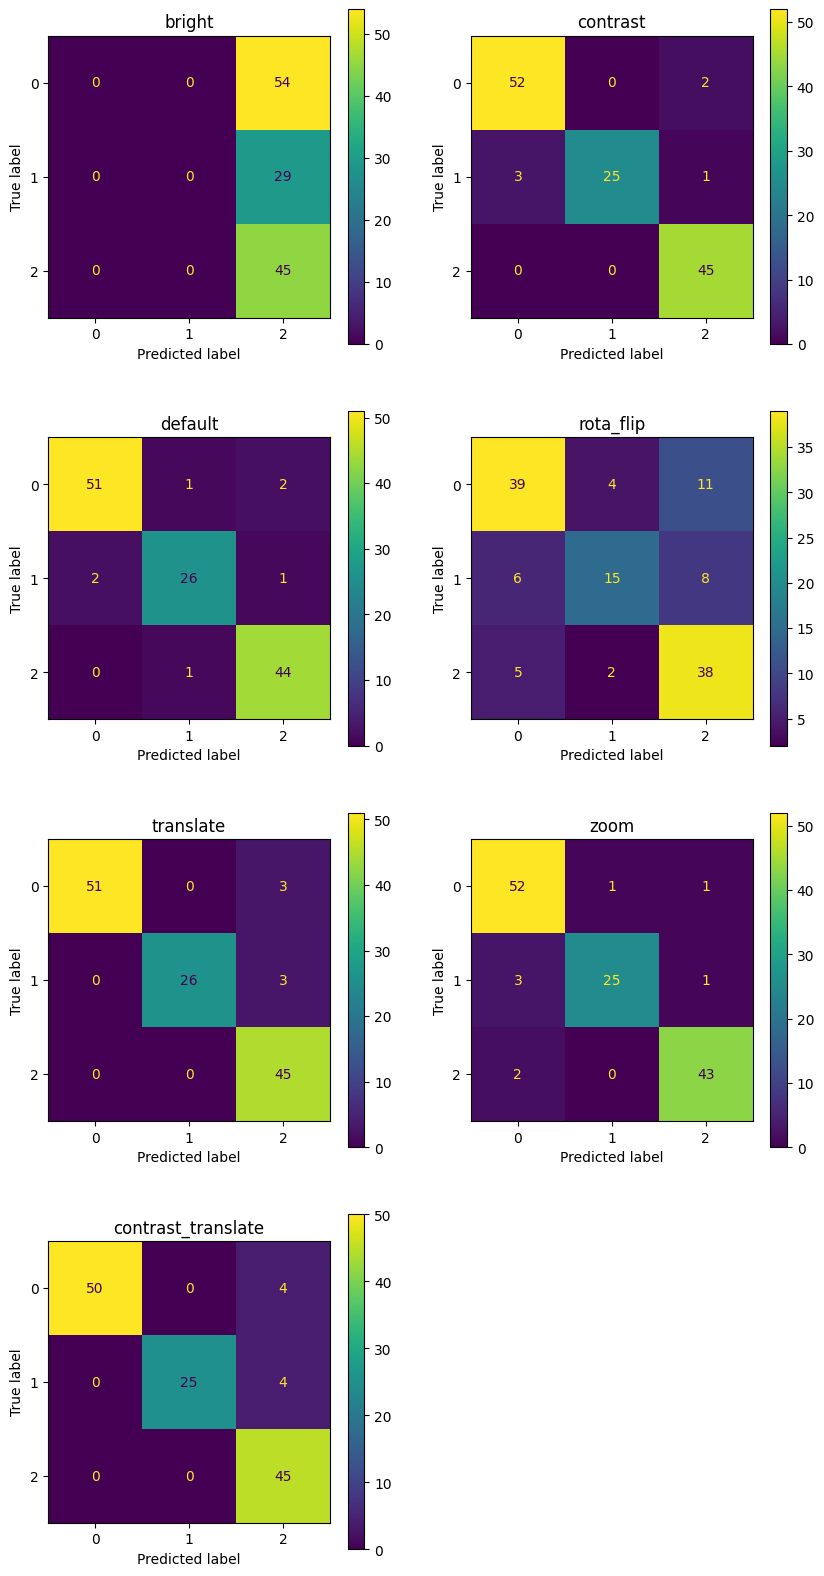

In [250]:
# load and display confusion matrixes
cols = 2
rows = 4
i = 1

fig = plt.figure(figsize=(10, 20))

for key in confusions:
    conf = np.array(confusions[key])

    plt.subplot(rows, cols, i)
    plt.title(key)

    ConfusionMatrixDisplay(conf).plot(ax=plt.gca())

    i += 1

0 default red default
1 rota_flip green rota_flip
2 bright blue bright
3 zoom purple zoom
4 contrast pink contrast
5 translate black translate
6 contrast_translate orange contrast_translate


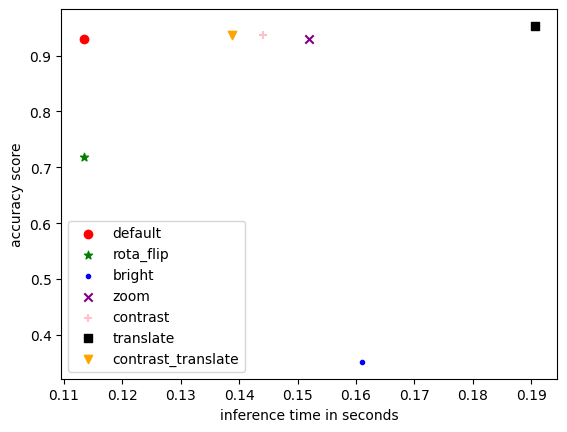

In [303]:
# display ic and ac (see: notes.txt)
keys = ["default", "rota_flip", "bright", "zoom", "contrast", "translate", "contrast_translate"]

labels = {"default" : "red", "rota_flip": "green", "bright": "blue", "zoom": "purple", "contrast": "pink", 
          "translate": "black", "contrast_translate": "orange"}

inf_time = [0.11346840858459473, 0.11346840858459473, 0.16101431846618652, 0.151991605758667, 
            0.14418649673461914, 0.19055724143981934, 0.1387939453125]

acc_score = [0.9296875, 0.71875, 0.3515625, 0.9296875, 0.9375, 0.953125, 0.9375]

colors = np.array(["red","green","blue","purple","pink","black","orange"])
markers = ["o", "*", ".", "x", "+", "s", "v"]

for i in range(0, len(keys)):
    print(i, keys[i], colors[i], keys[i])
    plt.scatter(inf_time[i], acc_score[i], c=colors[i], label=keys[i], marker=markers[i])


plt.xlabel("inference time in seconds")
plt.ylabel("accuracy score")
plt.legend(labels=keys)
plt.show()

## let's test our model in action

In [ ]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
if COLOR_CHANNELS == 1:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
cap.release()
plt.imshow(frame)

## manual cropping for demonstration purposes - you can do better!

In [ ]:
plt.imshow(frame[50:350, 60:210])

In [ ]:
resized = cv2.resize(frame[50:350, 60:210], SIZE)#[20:350, 200:420], SIZE)
plt.imshow(resized)
resized.shape

In [ ]:
reshaped = resized.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
reshaped.shape
prediction = model.predict(reshaped)

print(label_names[np.argmax(prediction)], np.max(prediction))

In [ ]:
filters, biases = model.layers[2].get_weights()
print(filters.shape)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        img = filters[:,:,:,i*8+j]
        axes[i][j].imshow(img)

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        #axes[i][j].imshow(filters[:,:,:,i*8+j] * 255, 'gray')
        kernel = filters[:,:,0,i*8+j]

        #print(kernel.shape)

        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        filtered = cv2.filter2D(gray, -1, kernel)

        axes[i][j].imshow(filtered, 'gray')

## Transfer Learning

let's use a pre-trained model (VGG16) for our prediction

note that VGG16 needs three color channels

In [ ]:
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 256

# load a VGG16 model trained on the imagenet dataset
# include_top=False -> do not include the output layer
# input_tensor -> tells the model about the dimensions of our images (VGG16 needs three color channels)
# pooling -> which type of pooling to use between convolutions; max or avg seem to be the best
VGG = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)), pooling='max')

# we want to use the VGG's original weights -> make those layers untrainable
for layer in VGG.layers:
    layer.trainable = False

# build a new model and add the VGG layers
model_vgg = Sequential()
model_vgg.add(VGG)

# append dense layers at the end
for i in range(layer_count - 1):
    model_vgg.add(Dense(num_neurons, activation=activation))
model_vgg.add(Dropout(0.2))

model_vgg.add(Dense(num_neurons, activation=activation))

# classifier
model_vgg.add(Dense(num_classes, activation='softmax'))

model_vgg.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history_vgg = model_vgg.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

In [ ]:
model_vgg.summary()

In [ ]:
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
accuracy = history_vgg.history['accuracy']
val_accuracy = history_vgg.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

In [ ]:
# let the model make predictions for our training data
y_predictions = model_vgg.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass